<a href="https://colab.research.google.com/github/shengy90/MSc-Project/blob/master/notebook/Data_Exploration_30th_June.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### **Authenticate with BigQuery ☁️**

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
%%bigquery --project machine-learning-msc df
SELECT 
  COUNT(*) as total_rows
FROM `machine-learning-msc.low_carbon_london.household_consumption_stats`

In [ ]:
df

,total_rows
0,167932474


### **Importing Libraries⏬**

In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import random

from datetime import date

sns.set()
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Exploring Dataset 🔭**

Note - this can take a while to download!

In [ ]:
%%bigquery --project machine-learning-msc df
SELECT 
*
FROM `machine-learning-msc.low_carbon_london.household_consumption_daily_stats` 
WHERE sample=0 

In [ ]:
%%bigquery --project machine-learning-msc df_monthly
WITH lcl_id_list AS (
    SELECT 
    lcl_id,
    EXTRACT(YEAR FROM month) AS year,
    COUNT(DISTINCT month) AS num_months
    FROM `machine-learning-msc.low_carbon_london.household_consumption_monthly_stats` 
    GROUP BY 1,2
    )

SELECT 
* EXCEPT(month, sample, tariff, stdortou), -- exclude redundant columns
CASE
    WHEN EXTRACT(month FROM month) = 1 THEN 'jan'
    WHEN EXTRACT(month FROM month) = 2 THEN 'feb'
    WHEN EXTRACT(month FROM month) = 3 THEN 'mar'
    WHEN EXTRACT(month FROM month) = 4 THEN 'apr'
    WHEN EXTRACT(month FROM month) = 5 THEN 'may'
    WHEN EXTRACT(month FROM month) = 6 THEN 'jun'
    WHEN EXTRACT(month FROM month) = 7 THEN 'jul'
    WHEN EXTRACT(month FROM month) = 8 THEN 'aug'
    WHEN EXTRACT(month FROM month) = 9 THEN 'sep'
    WHEN EXTRACT(month FROM month) = 10 THEN 'oct'
    WHEN EXTRACT(month FROM month) = 11 THEN 'nov'
    WHEN EXTRACT(month FROM month) = 12 THEN 'dec'
END AS month
FROM `machine-learning-msc.low_carbon_london.household_consumption_monthly_stats` 
WHERE lcl_id IN (SELECT lcl_id FROM lcl_id_list WHERE year = 2013 AND num_months = 12) -- select lcl_ids where we have full year record in 2013 (avoid missing data)
AND stdortou = "Std" -- select only households on standard tariff to avoid complications due to tariff prices on consumption
AND EXTRACT(year FROM MONTH) = 2013 -- only include 2013 data

### **Comparing daily load profiles of 3 random lcl_ids**

In [ ]:
df.head()

,lcl_id,month,day,acorn,acorn_grouped,sample,tariff,stdortou,daily_consumption,daily_consumption_stddev,daily_consumption_max,daily_consumption_min,daily_consumption_avg,month_to_date_cumulative_sum,month_to_date_cumulative_stddev,month_to_date_cumulative_max,month_to_date_cumulative_min,month_to_date_cumulative_avg
0,MAC000260,2012-04-01,2012-04-03,G,Comfortable,0,14.228,Std,6.064,0.116003,0.431,0.042,0.126333,56.120,2.667831,7.907,0.341,5.612000
1,MAC000260,2012-05-01,2012-05-21,G,Comfortable,0,14.228,Std,0.791,0.000505,0.017,0.016,0.016479,78.099,5.114741,20.531,0.790,2.693069
2,MAC000260,2012-12-01,2012-12-12,G,Comfortable,0,14.228,Std,8.069,0.132438,0.465,0.035,0.168104,247.305,1.727890,12.067,4.874,8.832321
3,MAC000260,2013-03-01,2013-03-02,G,Comfortable,0,14.228,Std,27.305,0.140881,1.297,0.451,0.568854,333.999,2.630828,28.436,18.761,22.266600
4,MAC000260,2013-05-01,2013-05-26,G,Comfortable,0,14.228,Std,5.131,0.099516,0.472,0.035,0.106896,91.034,1.314766,5.956,1.490,4.551700


In [ ]:
def pick_random_lclids(df, num):
    """
    Function to pick random `num` lcl_ids from dataset
    Parameters:
        df : input dataframe 
        num: number of lcl_ids to output
    """
    all_lcl_ids = list(set(df['lcl_id']))
    return np.random.choice(all_lcl_ids, num, replace=False) 

def plot_load_profiles(df, num):
    """
    Function to plot load profiles of `num` random lcl_ids from dataset
    Parameteres:
        df: input dataframe
        num: number of lcl_ids to plot
    """
    lcl_ids = pick_random_lclids(df, num)
    plot_df = pd.DataFrame(columns=df.columns)
    for lcl_id in lcl_ids:
        lcl_id_df = df.query(f"lcl_id == '{lcl_id}'")
        acorn_group = lcl_id_df.iloc[0]['acorn_grouped']
        acorn = lcl_id_df.iloc[0]['acorn']
        print(f"{lcl_id}: {acorn_group}, {acorn}")
        plot_df = pd.concat([plot_df, lcl_id_df])
    
    plt.figure(figsize=(20, 5))
    sns.lineplot(x='day', y="daily_consumption", data=plot_df, hue='lcl_id').set_title("Load profiles of 3 random lcl_ids")

MAC000979: Adversity, L
MAC004464: Adversity, K
MAC004178: Affluent, D


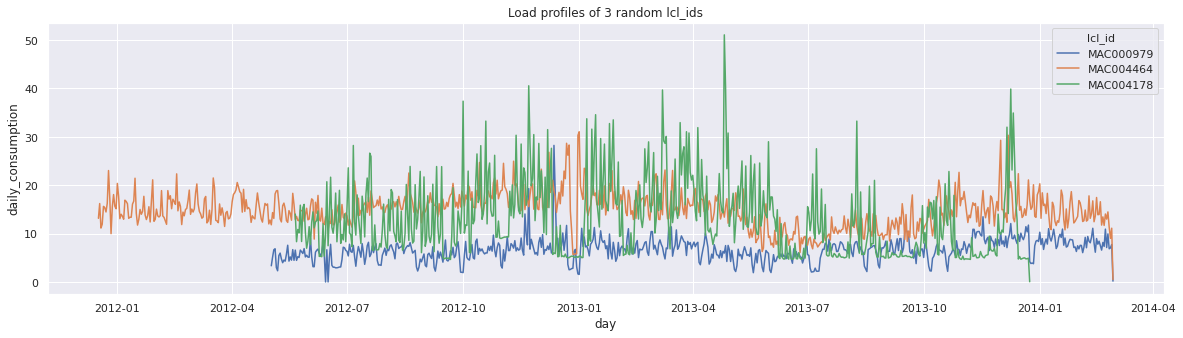

In [ ]:
plot_load_profiles(df, 3)

MAC004262: Comfortable, H
MAC002363: Comfortable, F
MAC002401: Comfortable, H


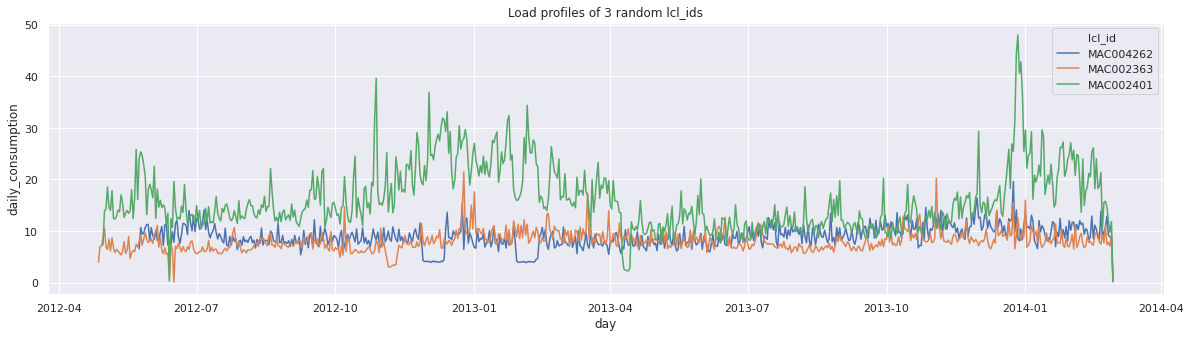

In [ ]:
plot_load_profiles(df, 3)

### **Comparing Monthly load profiles of 3 random lcl_ids**

In [ ]:
df_monthly.head()

,lcl_id,acorn,acorn_grouped,monthly_consumption,monthly_consumption_stddev,monthly_consumption_max,monthly_consumption_min,monthly_consumption_avg,month
0,MAC000002,A,Affluent,381.838000,0.311073,2.994,0.065,0.283894,feb
1,MAC000002,A,Affluent,410.124000,0.280157,2.095,0.072,0.284611,nov
2,MAC000002,A,Affluent,362.735001,0.216189,1.681,0.067,0.251724,apr
3,MAC000002,A,Affluent,270.050000,0.149907,1.266,0.075,0.181363,aug
4,MAC000002,A,Affluent,300.123000,0.173011,1.513,0.071,0.208274,jun


In [ ]:
df_monthly_wide = df_monthly.pivot(index='lcl_id', 
                                   columns='month',
                                   values=['monthly_consumption', 
                                            'monthly_consumption_stddev', 
                                            'monthly_consumption_max',
                                            'monthly_consumption_min',
                                            'monthly_consumption_avg']
                                    )
df_monthly_wide.columns = ['_'.join(col) for col in df_monthly_wide.columns]

In [ ]:
df_monthly_wide.head()

,monthly_consumption_apr,monthly_consumption_aug,monthly_consumption_dec,monthly_consumption_feb,monthly_consumption_jan,monthly_consumption_jul,monthly_consumption_jun,monthly_consumption_mar,monthly_consumption_may,monthly_consumption_nov,monthly_consumption_oct,monthly_consumption_sep,monthly_consumption_stddev_apr,monthly_consumption_stddev_aug,monthly_consumption_stddev_dec,monthly_consumption_stddev_feb,monthly_consumption_stddev_jan,monthly_consumption_stddev_jul,monthly_consumption_stddev_jun,monthly_consumption_stddev_mar,monthly_consumption_stddev_may,monthly_consumption_stddev_nov,monthly_consumption_stddev_oct,monthly_consumption_stddev_sep,monthly_consumption_max_apr,monthly_consumption_max_aug,monthly_consumption_max_dec,monthly_consumption_max_feb,monthly_consumption_max_jan,monthly_consumption_max_jul,monthly_consumption_max_jun,monthly_consumption_max_mar,monthly_consumption_max_may,monthly_consumption_max_nov,monthly_consumption_max_oct,monthly_consumption_max_sep,monthly_consumption_min_apr,monthly_consumption_min_aug,monthly_consumption_min_dec,monthly_consumption_min_feb,monthly_consumption_min_jan,monthly_consumption_min_jul,monthly_consumption_min_jun,monthly_consumption_min_mar,monthly_consumption_min_may,monthly_consumption_min_nov,monthly_consumption_min_oct,monthly_consumption_min_sep,monthly_consumption_avg_apr,monthly_consumption_avg_aug,monthly_consumption_avg_dec,monthly_consumption_avg_feb,monthly_consumption_avg_jan,monthly_consumption_avg_jul,monthly_consumption_avg_jun,monthly_consumption_avg_mar,monthly_consumption_avg_may,monthly_consumption_avg_nov,monthly_consumption_avg_oct,monthly_consumption_avg_sep
lcl_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MAC000002,362.735001,270.050,376.965,381.838000,360.082000,271.321000,300.123,480.170000,304.064,410.124000,378.352,321.740,0.216189,0.149907,0.235025,0.311073,0.212572,0.150897,0.173011,0.365321,0.174953,0.280157,0.247154,0.222055,1.681,1.266,2.352,2.994,1.603,1.546,1.513,2.524,1.398,2.095,1.965,1.751,0.067,0.075,0.073,0.065,0.071,0.069,0.071,0.065,0.068,0.072,0.075,0.065,0.251724,0.181363,0.253167,0.283894,0.241828,0.182217,0.208274,0.322478,0.204207,0.284611,0.254098,0.223276
MAC000003,718.258000,356.117,506.836,1075.075001,1070.275003,368.700001,359.975,955.680999,374.173,537.029001,348.271,358.872,0.769889,0.297434,0.501300,1.010616,0.938757,0.294278,0.312244,0.955062,0.319948,0.539436,0.303459,0.305813,3.757,1.526,2.844,3.366,3.575,1.729,1.617,3.729,1.523,2.719,1.559,1.573,0.046,0.027,0.028,0.036,0.034,0.026,0.025,0.007,0.023,0.033,0.034,0.032,0.498444,0.239165,0.340387,0.799312,0.718788,0.247616,0.249809,0.642259,0.251460,0.372678,0.233896,0.249044
MAC000004,50.430000,45.362,54.664,56.975000,55.968000,43.274000,51.879,59.342000,49.961,51.895000,51.397,47.600,0.070893,0.066350,0.070056,0.087896,0.074554,0.065755,0.068893,0.076609,0.069761,0.070038,0.070430,0.068013,0.326,0.299,0.313,0.690,0.629,0.313,0.279,0.548,0.264,0.294,0.353,0.318,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.034997,0.030465,0.036712,0.042361,0.037588,0.029062,0.036002,0.039854,0.033576,0.036013,0.034518,0.033033
MAC000006,91.244000,47.119,114.048,103.293000,82.859000,89.490000,78.216,104.054000,86.172,97.070000,90.055,70.623,0.058959,0.044129,0.063459,0.070157,0.059087,0.045912,0.042065,0.060012,0.047016,0.050802,0.045288,0.045227,0.736,0.469,0.703,0.774,0.657,0.547,0.570,0.725,0.601,0.607,0.575,0.450,0.013,0.000,0.013,0.013,0.000,0.013,0.013,0.013,0.013,0.013,0.013,0.000,0.063320,0.031645,0.076594,0.076798,0.055647,0.060101,0.054279,0.069882,0.057872,0.067363,0.060480,0.049010
MAC000007,300.981000,243.602,383.905,267.420000,303.734000,268.484000,244.307,406.010000,256.376,265.658000,272.601,206.899,0.236393,0.161536,0.344860,0.225821,0.223118,0.172641,0.179330,0.345418,0.205442,0.201506,0.200572,0.174261,1.838,1.553,3.784,1.755,1.691,1.685,1.614,3.090,1.778,1.597,1.608,1.365,0.024,0.020,0.017,0.026,0.026,0.024,0.020,0

##### **Try basic PCA and clustering**

TL;DR - no good - these stats aren't good enough to form distinct clusters.


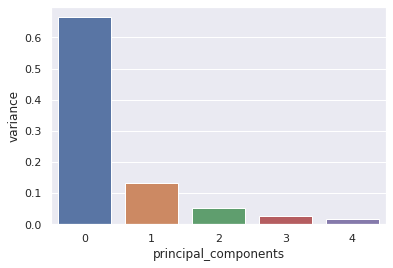

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

normalised_df = StandardScaler().fit_transform(df_monthly_wide)
pca = PCA(n_components=5)
principal_components = pca.fit_transform(normalised_df)
pca_df = pd.DataFrame(
    {'variance' : pca.explained_variance_ratio_,
     'principal_components': range(pca.n_components)}
     )
sns.barplot(x='principal_components', y='variance', data=pca_df)

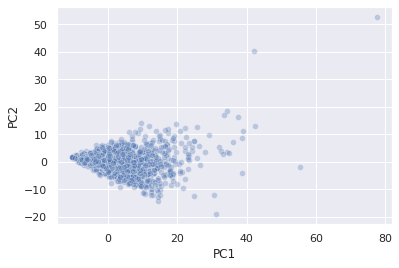

In [ ]:
pca_components = pd.DataFrame(
    index=df_monthly_wide.index,
    columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'],
    data = principal_components
    )
sns.scatterplot(x='PC1', y='PC2', data=pca_components, alpha=0.3)